1. load input image and user edit prompt
2. operate VLM (Qwen to extract the parameters): id, class, bbox, matrix.
3. operate SAM to extract the binary mask
4. operate open-CV to to compute the shape mask.
5. operate SDL drawer with shape mask

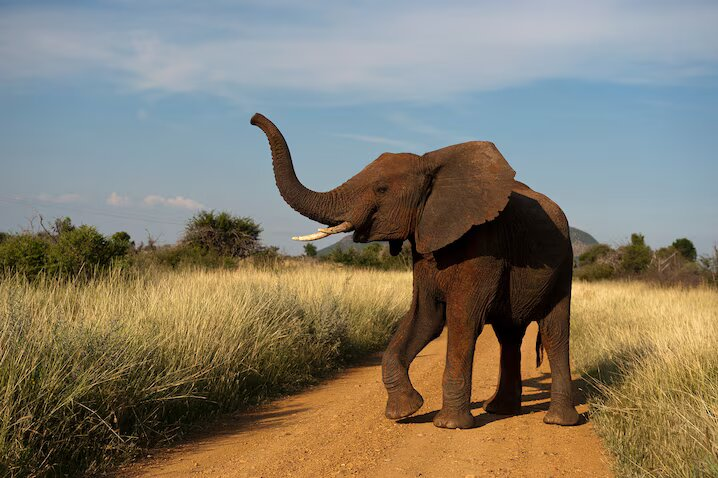

Text(value='', description='User Prompt:', placeholder='Enter your prompt here')

/dtu/blackhole/14/189044/marscho/cache/tmp/ipykernel_3035712/1004401770.py:33: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  user_prompt_widget.on_submit(print_user_prompt)


In [2]:
# 1. load inputs (source image and user prompt)

import ipywidgets as widgets
from IPython.display import display, Image as IPImage
from PIL import Image

# Fixed image path
image_path = "data/elephant.jpg"

# Load the image using PIL
try:
    source_image = Image.open(image_path)
    # Display the image inline in the notebook
    display(IPImage(filename=image_path))
except FileNotFoundError:
    print("File not found. Please check the path and try again.")

# Create a text box widget for the user prompt
user_prompt_widget = widgets.Text(
    description='User Prompt:',
    placeholder='Enter your prompt here'
)

# Display the widget
display(user_prompt_widget)

# Function to print the user prompt
def print_user_prompt(change):
    user_prompt = user_prompt_widget.value
    print(f"User prompt: {user_prompt}")

# Attach the function to the user prompt widget to trigger on 'submit'
user_prompt_widget.on_submit(print_user_prompt)

In [ ]:
# 3. use QWEN-VL to parse the parameters
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation import GenerationConfig
import torch
torch.manual_seed(1234)

# Note: The default behavior now has injection attack prevention off.
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)

# use bf16
# model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="auto", trust_remote_code=True, bf16=True).eval()
# use fp16
# model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="auto", trust_remote_code=True, fp16=True).eval()
# use cpu only
# model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="cpu", trust_remote_code=True).eval()
# use cuda device with bf16
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="cuda", trust_remote_code=True, bf16=True).eval()

# Specify hyperparameters for generation
model.generation_config = GenerationConfig.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)

# 1st dialogue turn
query = tokenizer.from_list_format([
    {'image': 'https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg'}, # Either a local path or an url
    {'text': '这是什么?'},
])
response, history = model.chat(tokenizer, query=query, history=None)
print(response)
# 图中是一名女子在沙滩上和狗玩耍，旁边是一只拉布拉多犬，它们处于沙滩上。

# 2nd dialogue turn
response, history = model.chat(tokenizer, '框出图中击掌的位置', history=history)
print(response)
# <ref>击掌</ref><box>(536,509),(588,602)</box>
image = tokenizer.draw_bbox_on_latest_picture(response, history)
if image:
  image.save('1.jpg')
else:
  print("no box")

In [3]:
# https://github.com/QwenLM/Qwen2.5-Math

 
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-Math-72B-Instruct"
device = "cuda" # the device to load the model onto

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

prompt = "Find the value of $x$ that satisfies the equation $4x+5 = 6x+7$."

# CoT
messages = [
    {"role": "system", "content": "Please reason step by step, and put your final answer within \\boxed{}."},
    {"role": "user", "content": prompt}
]

# TIR
messages = [
    {"role": "system", "content": "Please integrate natural language reasoning with programs to solve the problem above, and put your final answer within \\boxed{}."},
    {"role": "user", "content": prompt}
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

/dtu/blackhole/14/189044/marscho/VLM_controller_for_SD/.venv/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


model-00007-of-00037.safetensors:  14%|#4        | 535M/3.81G [00:00<?, ?B/s]

In [ ]:
# 4. use OPENCV to generate new mask

In [ ]:
# Cell 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Cell 2: Create some data
x = np.linspace(10, 20, 100)
y = np.sin(x)

# Cell 3: Plot the data
plt.plot(x, y)
plt.title('Sine Wave')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.show()

# Cell 4: A simple test function
def add(a, b):
    return a + b

# Cell 5: Test the function
assert add(2, 3) == 5, "Test failed!"
print("Test passed!")

       